# Forecasting the P/Sales Ratio

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

In a [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) we found a mathematical formula for doing long-term stock forecasting. The formula was derived from the definition of annualized return and separated the stock-return into 3 components: Dividends, change in the Sales Per Share, and change in the P/Sales ratio. If you can predict these 3 components, then you can predict the future stock-return.

This makes intuitive sense, because if you buy a stock and hold it for some years, then you get dividends during those years, and the change in share-price can be decomposed into the change in Sales Per Share and the change in P/Sales ratios using this simple identity:

$$
{Share\ Price_t} = Sales\ Per\ Share_t \cdot \frac{Share\ Price_t}{Sales\ Per\ Share_t} \\
= Sales\ Per\ Share_t \cdot P/Sales_t
$$

So the change in share-price is equal to the change in Sales Per Share multiplied by the change in P/Sales ratio:

$$
\frac{Share\ Price_{t + Years}}{Share\ Price_t} =
\frac{Sales\ Per\ Share_{t + Years} \cdot P/Sales_{t + Years}}{Sales\ Per\ Share_t \cdot P/Sales_t} \\
= \frac{Sales\ Per\ Share_{t + Years}}{Sales\ Per\ Share_t} \cdot
\frac{P/Sales_{t + Years}}{P/Sales_t}
$$

Note that we could also use the change in Earnings Per Share and P/E ratios instead, but the Earnings (aka. Net Income) can be more unstable than Sales, because of temporary fluctuations in profit margins, as well as non-cash and/or non-recurring gains and losses. That is why we will use the P/Sales ratio here.

This paper is a basic statistical study of how to predict the future P/Sales ratio.

## Imports

In [1]:
from simfin.names import *

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display_jpeg

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as sm

# SimFin imports.
import simfin as sf
from simfin.names import *
from simfin.utils import BDAYS_PER_YEAR

In [3]:
# Version of the SimFin Python API.
sf.__version__

'0.5.0'

## Config

Setup and configure the various Python packages we are using.

In [4]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [5]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [6]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Data-Hub

We use [SimFin](https://github.com/SimFin/simfin) to easily load and process financial data with the following settings:

In [7]:
hub_args = \
{
    # We are interested in the US stock-market.
    'market': 'us',

    # Add this date-offset to the fundamental data such as
    # Income Statements etc., because the REPORT_DATE is not
    # when it was actually made available to the public,
    # which can be 1, 2 or even 3 months after the Report Date.
    'offset': pd.DateOffset(days=60),
    
    # Use last-known values to fill in missing values.
    'fill_method': 'ffill',

    # Refresh the fundamental datasets (Income Statements etc.)
    # every 30 days.
    'refresh_days': 30,

    # Refresh the dataset with shareprices every 10 days.
    'refresh_days_shareprices': 10
}

We can then create a `StockHub` object to handle all the data and signal processing:

In [8]:
%%time
hub = sf.StockHub(**hub_args)

CPU times: user 10 µs, sys: 3 µs, total: 13 µs
Wall time: 17.6 µs


## Signals

We can now use the stock-hub to calculate the signals that we will be using in our analysis, such as P/Sales, Net Profit Margin, Sales Growth, etc. We create a small helper-function for calculating and combining all the signals we need:

In [9]:
def all_signals(func=None, winsorize_quantile=0.03):
    """
    Calculate Financial, Growth, and Valuation signals.
    
    :param func:
        Function or callable object passed to signal-functions
        e.g. to calculate 3-year averages: `func=sf.avg_ttm_3y`
    
    :param winsorize_quantile:
        Float with the winsorization quantile.
        If `None` then winsorization is not performed.
        
    :return:
        Pandas DataFrame with signals.
    """
    
    # Financial Signals.
    df_fin_signals = hub.fin_signals(variant='daily', func=func)
    
    # Growth Signals.
    df_growth_signals = hub.growth_signals(variant='daily', func=func)
    
    # Valuation Signals.
    df_val_signals = hub.val_signals(variant='daily', func=func)

    # Combine into a single DataFrame.
    dfs = [df_fin_signals, df_growth_signals, df_val_signals]
    df_signals = pd.concat(dfs, axis=1)

    # Winsorize the signals?
    if winsorize_quantile is not None:
        # Don't Winsorize these columns.
        exclude_columns = [MARKET_CAP]
        
        # Remove outliers by setting them to NaN.
        df_signals = sf.winsorize(df=df_signals, clip=False,
                                  quantile=winsorize_quantile,
                                  exclude_columns=exclude_columns)
    
    return df_signals

We can now run the function to calculate all the signals. This may take several minutes the first time you run it. After that, it will automatically load the cached results from disk, until the underlying datasets are downloaded again from the SimFin server, at which point the signal-functions will be called again and new disk-cache files will be created.

In [10]:
%%time
df_signals = all_signals()

Dataset "us-income-ttm" on disk (14 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (14 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (1 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-2a38bb7d.pickle' on disk (3 days old).
- Running function fin_signals() ... Done!
- Saving cache-file to disk ... Done!
Dataset "us-income-quarterly" on disk (14 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (12 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (14 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (14 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-2a38bb7d.pickle' on disk (3 days old).
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
Cache-file 'val_signals-739b68a6.pickle' on disk (3 days old).
- Running function val_signals() ... Done!
- Saving cache-file to disk ...

This is what the resulting DataFrames look like:

In [11]:
df_signals.dropna(how='all').head()

Asset Turnover  Current Ratio  Debt Ratio  \
Ticker Date                                                    
A      2011-06-29        0.711759       3.201005     0.24789   
       2011-06-30        0.711759       3.201005     0.24789   
       2011-07-01        0.711759       3.201005     0.24789   
       2011-07-05        0.711759       3.201005     0.24789   
       2011-07-06        0.711759       3.201005     0.24789   

                   Gross Profit Margin  Interest Coverage  Net Profit Margin  \
Ticker Date                                                                    
A      2011-06-29             0.532001          10.890411           0.144574   
       2011-06-30             0.532001          10.890411           0.144574   
       2011-07-01             0.532001          10.890411           0.144574   
       2011-07-05             0.532001          10.890411           0.144574   
       2011-07-06             0.532001          10.890411           0.144574   

                   Return on Assets  Return on Equity  Assets Growth  \
Ticker Date                                                            
A      2011-06-29          0.102902          0.224691            NaN   
       2011-06-30          0.102902          0.224691            NaN   
       2011-07-01          0.102902          0.224691            NaN   
       2011-07-05          0.102902          0.224691            NaN   
       2011-07-06          0.102902          0.224691            NaN   

                   Assets Growth QOQ  ...  Dividend Yield  Earnings Yield  \
Ticker Date                           ...                                   
A      2011-06-29                NaN  ...             NaN        0.049626   
       2011-06-30                NaN  ...             NaN        0.049121   
       2011-07-01                NaN  ...             NaN        0.048280   
       2011-07-05                NaN  ...             NaN        0.048598   
       2011-07-06                NaN  ...             NaN        0.048448   

                   FCF Yield    Market-Cap    P/Book        P/E      P/FCF  \
Ticker Date                                                                  
A      2011-06-29   0.045221  1.793416e+10  4.527684  20.150736  22.113631   
       2011-06-30   0.044761  1.811850e+10  4.574222  20.357860  22.340931   
       2011-07-01   0.043995  1.843400e+10  4.653875  20.712360  22.729963   
       2011-07-05   0.044284  1.831347e+10  4.623446  20.576933  22.581344   
       2011-07-06   0.044148  1.837019e+10  4.637766  20.640663  22.651282   

                      P/NCAV   P/NetNet   P/Sales  
Ticker Date                                        
A      2011-06-29  43.956262 -29.990226  2.913281  
       2011-06-30  44.408076 -30.298487  2.943225  
       2011-07-01  45.181373 -30.826087  2.994477  
       2011-07-05  44.885956 -30.624532  2.974898  
       2011-07-06  45.024975 -30.719381  2.984111  

[5 rows x 30 columns]

We can also calculate 3-year averages for the signals, so instead of using e.g. just a single year's Net Profit Margin which may be quite volatile, we can smoothen it by using 3-year averages. Further below we will test if this is better at predicting future P/Sales ratios.

In [12]:
%%time
df_signals_3y = all_signals(func=sf.avg_ttm_3y)

Cache-file 'fin_signals-2186bbb1.pickle' on disk (3 days old).
- Running function fin_signals() ... Done!
- Saving cache-file to disk ... Done!
Cache-file 'growth_signals-2186bbb1.pickle' on disk (3 days old).
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
Cache-file 'val_signals-65726cdc.pickle' on disk (3 days old).
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 4min 9s, sys: 8.36 s, total: 4min 18s
Wall time: 4min 19s


## P/Sales Signals

Let us now create a new Pandas DataFrame just for the P/Sales signals that we want to predict. We first copy the basic P/Sales signal from the DataFrame we calculated above. Then we add a few more columns to the DataFrame:

- `PSALES_3Y_PAST`: The average P/Sales ratio for the PAST 3 years.
- `PSALES_3Y_FUTURE`: The average P/Sales ratio for the FUTURE 3 years.
- `PSALES_REL_PAST`: The daily P/Sales ratio divided by its PAST 3-year average.
- `PSALES_REL_FUTURE`: The FUTURE 3-year average divided by the daily P/Sales.

In [13]:
%%time
# Copy the P/Sales column to a new DataFrame.
# Note that we select a list of columns to create a DataFrame,
# so we can add more columns to it.
df_psales = df_signals[[PSALES]].copy()

# Convert 3 years to the equivalent number of trading-days.
periods_3y, _ = sf.convert_to_periods(freq='bdays', years=3)

# Calculate the PAST 3-year average P/Sales ratios.
# Note the use of groupby to ensure the different stock-tickers
# are processed individually.
PSALES_3Y_PAST = 'P/Sales 3Y Avg. PAST'
df_psales[PSALES_3Y_PAST] = df_psales[PSALES] \
    .groupby(TICKER, group_keys=False) \
    .rolling(window=periods_3y).mean()

# Calculate the FUTURE 3-year average P/Sales ratios.
# Note that we again use groupby to ensure the different
# stock-tickers are processed individually. Also note
# the 1-periods_3y in the shifting, to properly align the data.
PSALES_3Y_FUTURE = 'P/Sales 3Y Avg. FUTURE'
df_psales[PSALES_3Y_FUTURE] = df_psales[PSALES_3Y_PAST] \
    .groupby(TICKER, group_keys=False).shift(1-periods_3y)

# Calculate the current P/Sales divided by its PAST 3-year average.
# Note that we do not need to use groupby for this, because
# we only use data from within the same row of the DataFrame.
PSALES_REL_PAST = '(P/Sales) / (P/Sales 3Y Avg. PAST)'
df_psales[PSALES_REL_PAST] = df_psales[PSALES] / df_psales[PSALES_3Y_PAST]

# Calculate the FUTURE 3-year average div. by current P/Sales.
PSALES_REL_FUTURE = '(P/Sales 3Y Avg. FUTURE) / (P/Sales)'
df_psales[PSALES_REL_FUTURE] = df_psales[PSALES_3Y_FUTURE] / df_psales[PSALES]

CPU times: user 3.03 s, sys: 104 ms, total: 3.13 s
Wall time: 3.14 s


These are the resulting P/Sales ratios for ticker MSFT:

In [14]:
df_psales.loc['MSFT'].dropna(how='all')

,P/Sales,P/Sales 3Y Avg. PAST,P/Sales 3Y Avg. FUTURE,(P/Sales) / (P/Sales 3Y Avg. PAST),(P/Sales 3Y Avg. FUTURE) / (P/Sales)
Date,,,,,
2010-06-01,3.890739,NaN,3.469545,NaN,0.891744
2010-06-02,3.976399,NaN,3.469552,NaN,0.872536
2010-06-03,4.036511,NaN,3.469547,NaN,0.859541
2010-06-04,3.875712,NaN,3.469373,NaN,0.895158
2010-06-07,3.800572,NaN,3.469382,NaN,0.912858
...,...,...,...,...,...
2020-03-10,9.253418,7.500059,NaN,1.233779,NaN
2020-03-11,8.834220,7.504583,NaN,1.177177,NaN
2020-03-12,7.996398,7.508022,NaN,1.065047,NaN


For convenience, let us add these columns to the DataFrames with all the other signals.

In [15]:
%%time
# Add new P/Sales columns to DataFrame with normal signals.
dfs = [df_signals, df_psales.drop(columns=[PSALES])]
df_signals = pd.concat(dfs, axis=1)

# Add new P/Sales columns to DataFrame with 3-year avg. signals.
dfs = [df_signals_3y, df_psales.drop(columns=[PSALES])]
df_signals_3y = pd.concat(dfs, axis=1)

CPU times: user 404 ms, sys: 196 ms, total: 600 ms
Wall time: 598 ms


## Data Years

Let us see how many years of P/Sales data we have for all the different stocks. First we need a small helper-function:

In [16]:
def data_years(df):
    """
    Calculate the number of years of data in DataFrame `df`.
    
    :param df:
        Pandas DataFrame assumed to have daily data and be
        grouped by TICKER, and not have any empty NaN rows.

    :return:
        Pandas Series with number of years for each TICKER.
    """

    # Count the number of data-points for each ticker.
    df_data_days = df.groupby(TICKER).apply(lambda df_grp: len(df_grp))

    # Calculate the number of years of data for each ticker.
    # This is the number of days divided by the average
    # number of business/trading-days per year.
    df_data_years = df_data_days / BDAYS_PER_YEAR
    
    return df_data_years

On average we have about 6 years of P/Sales data for all these stocks:

In [17]:
# Calculate the number of years of P/Sales data for all stocks.
df_data_years = data_years(df=df_psales[PSALES].dropna())

# Show statistics.
df_data_years.describe()

count    1723.000000
mean        6.305951
std         2.895633
min         0.003973
25%         4.048953
50%         7.537649
75%         8.793261
max        11.288592
Name: P/Sales, dtype: float64

We can also plot a histogram, so we can see the distribution of how many years of P/Sales data we have for all the individual companies:

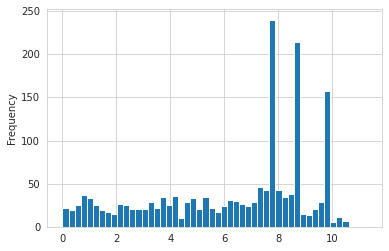

In [18]:
df_data_years.plot(kind='hist', bins=50);

In the scatter-plots further below, we will compare the current P/Sales ratio to the 3-year FUTURE average P/Sales. The summary statistics below shows that on average there is a bit more than 4 years of such data per company, for a total of nearly 1400 companies:

In [19]:
df = df_psales[[PSALES, PSALES_3Y_FUTURE]].dropna(how='any')
data_years(df=df).describe()

count    1369.000000
mean        4.310333
std         1.995259
min         0.043708
25%         2.801287
50%         4.795963
75%         5.797274
max         8.292605
dtype: float64

In another scatter-plot further below we will compare the PAST 3-year average P/Sales to the FUTURE 3-year average P/Sales. The statistics below show that there was only a bit more than 2 years of data-points per company, for a total of about 1000 companies:

In [20]:
df = df_psales[[PSALES_3Y_PAST, PSALES_3Y_FUTURE]].dropna(how='any')
data_years(df=df).describe()

count    1013.000000
mean        2.336781
std         1.055751
min         0.019867
25%         1.796003
50%         2.296658
75%         2.876783
max         5.296619
dtype: float64

This is a fairly short data-period, because the SimFin database currently does not have any more data. What this means for our analysis, is that we should interpret the results with some caution, as the data may contain trends that are unique for that period in time.

## Plotting Functions

These are small helper-functions for making plots.

In [21]:
def plot_with_mean(df):
    """
    Make line-plot and a horizontal line for the mean.
    
    :param df:
        Pandas DataFrame with a time-series.
        
    :return:
        Matplotlib axes object.
    """

    # Plot the time-series.
    ax = df.dropna().plot()
    
    # Overlay the plot with a horizontal line for the mean.
    ax.axhline(df.mean(), c='red')
    
    return ax

In [22]:
def plot_scatter(df, x, y, hue=None, num_samples=5000):
    """
    Make a scatter-plot using a random sub-sample of the data.
    
    :param df:
        Pandas DataFrame with columns named `x`, `y` and `hue`.

    :param x:
        String with column-name for the x-axis.

    :param y:
        String with column-name for the y-axis.

    :param hue:
        Either None or string with column-name for the hue.

    :param num_samples:
        Int with number of random samples for the scatter-plot.

    :return:
        matplotlib Axes object
    """

    # Select the relevant columns from the DataFrame.
    if hue is None:
        df = df[[x, y]].dropna()
    else:
        df = df[[x, y, hue]].dropna()

    # Only plot a random sample of the data-points?
    if num_samples is not None and len(df) > num_samples:
        idx = np.random.randint(len(df), size=num_samples)
        df = df.iloc[idx]

    # Ensure the plotting area is a square.
    plt.figure(figsize=(5,5))

    # Make the scatter-plot.
    ax = sns.scatterplot(x=x, y=y, hue=hue, s=20,
                         data=df.reset_index())

    # Move legend for the hue.
    if hue is not None:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    return ax

In [23]:
def plot_scatter_fit(df, x, y, num_samples=5000):
    """
    Make a scatter-plot and fit a line through the points.
    
    If there are many data-points, you can use a random
    sample for the scatter-plot, but the linear formula
    is still found using all the data-points.
    
    :param df:
        Pandas DataFrame with columns named `x` and `y`.

    :param x:
        String with column-name for the x-axis.

    :param y:
        String with column-name for the y-axis.

    :param num_samples:
        Int with number of random samples for the scatter-plot.

    :return:
        matplotlib Axes object
    """
    
    # Select the relevant columns from the DataFrame.
    df = df[[x, y]].dropna(how='any').reset_index()

    # Fit a line through all the data-points and get stats.
    slope, intercept, r_value, p_value, std_err = \
        linregress(x=df[x], y=df[y])

    # Show the fitted line and its stats.
    msg = 'y = {0:.2f} * x + {1:.2f} (R^2={2:.2f}, p={3:.0e})'
    msg = msg.format(slope, intercept, r_value**2, p_value)
    print(msg)
    
    # Only plot a random sample of the data-points?
    if num_samples is not None and len(df) > num_samples:
        idx = np.random.randint(len(df), size=num_samples)
        df = df.iloc[idx]

    # Make the scatter-plot with a fitted line.
    # This uses the smaller sample of data-points.
    ax = sns.jointplot(x=x, y=y, kind='reg', data=df,
                       line_kws={'color': 'red'},
                       scatter_kws={'s': 2})

    return ax

## Regression Function

This is a small helper-function for doing multiple linear regression.

In [24]:
def regression(df, y, standardize=True, use_constant=True):
    """
    Perform multiple linear-regression on the given DataFrame.
    
    :param df:
        Pandas DataFrame with signals and returns.
        
    :param y:
        String with column-name for the dependent variable.
        This will be taken from the DataFrame `df`.
        
    :param standardize:
        Boolean whether to standardize the predictor variables
        so they have 0 mean and 1 standard deviation.

    :param use_constant:
        Boolean whether to add a 'Constant' column to
        find the bias.
    
    :return:
        StatsModels Regression Results.
    """
    
    # Remove rows with missing values.
    df = df.dropna(how='any').copy()

    # DataFrame for the x-signals.
    df_x = df.drop(columns=[y])
    
    # DataFrame for the y-signal.
    df_y = df[y]

    # Standardize the signals so they have mean 0 and std 1.
    if standardize:
        df_x = (df_x - df_x.mean()) / df_x.std()

    # Add a "constant" column so the regression can find the bias.
    if use_constant:
        df_x['Constant'] = 1.0

    # Perform the regression on this data.
    model = sm.OLS(df_y, df_x).fit()
    
    return model

## P/Sales Self-Prediction

Let us now consider how the current P/Sales ratio is related to the future 3-year average P/Sales ratios. We use our helper-function to make a scatter-plot and fit a straight line through the data.

Each dot in the scatter-plot has on the x-axis the P/Sales ratio for some company's stock at some date, and on the y-axis is the average P/Sales ratio from the same date and going 3 years into the future.

Also note that the scatter-plot only uses a sample of 5000 randomly selected points from the dataset, because there is actually more than a million data-points, which would make the plotting very slow (or even crash the program), and even if it worked, it would make the plot very messy to look at. The red line on the plot is fitted to those 5000 randomly selected data-points, while the linear formula printed at the top, is fitted to all of the data-points.

We see that the fitted line is roughly $y = 0.9 * x + 0.4$ with $R^2=0.82$ so it is a really good fit, that shows the current P/Sales ratio is a strong predictor for the future 3-year average P/Sales ratios.

y = 0.88 * x + 0.43 (R^2=0.82, p=0e+00)


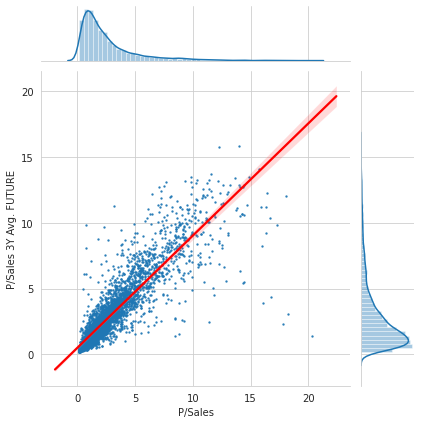

In [25]:
plot_scatter_fit(df=df_psales, x=PSALES, y=PSALES_3Y_FUTURE);

We can also compare the PAST 3-year average P/Sales to the FUTURE 3-year average P/Sales. The scatter-plot is shown below and it is very similar to the scatter-plot above. The fitted line has a slope of nearly 1, and the intercept is about 0.4 so the fitted line is roughly $y=x + 0.4$ with $R^2 = 0.78$, so the fit is nearly as good as above. The small bias suggests the stocks have generally seen a small upwards revaluation over the time-period being considered in this dataset, we will discuss this in more detail below.

y = 0.95 * x + 0.36 (R^2=0.78, p=0e+00)


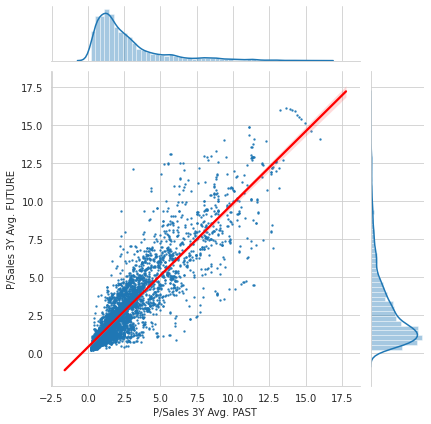

In [26]:
plot_scatter_fit(df=df_psales,
                 x=PSALES_3Y_PAST, y=PSALES_3Y_FUTURE);

The scatter-plots above show us that **in aggregate**, the stocks tend to have the same average P/Sales ratios in the FUTURE 3-years as they did in the PAST 3-years. But the **individual** stocks can experience significant changes in their P/Sales ratios.

The following scatter-plot shows the 3-year average PAST P/Sales ratio on the x-axis, and the 3-year average FUTURE P/Sales ratio on the y-axis. The hue of the dots is the current P/Sales ratio divided by its PAST 3-year average P/Sales, where a value below 1 shows that the current P/Sales ratio is below its PAST 3-year average, and vice versa for a value above 1.

In the plot below, we can see that the dots with light hue tend to be below the diagonal, and the dots with dark hue tend to be above the diagonal. This indicates that stocks whose P/Sales has recently dropped below its PAST 3-year average, tend to stay down and have a lower average P/Sales in the FUTURE 3-years.

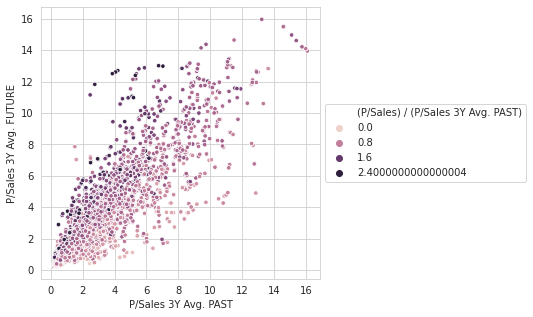

In [27]:
# Limit some of the data-points to more clearly show the hue.
lower = {PSALES_REL_PAST: 0, PSALES_REL_FUTURE: 0}
upper = {PSALES_REL_PAST: 2, PSALES_REL_FUTURE: 2}
df_psales2 = sf.clip(df=df_psales, lower=lower, upper=upper)

plot_scatter(x=PSALES_3Y_PAST, y=PSALES_3Y_FUTURE,
             hue=PSALES_REL_PAST, df=df_psales2);

Let us consider another scatter-plot, where the x-axis is the current P/Sales ratio divided by its PAST 3-year average P/Sales, and the y-axis is the FUTURE 3-year average P/Sales divided by its current P/Sales ratio.

This is another way of showing if a recent change in P/Sales ratio compared to its PAST 3-year average, can serve as a predictor for the FUTURE change over the following 3 years.

The plot shows a blob of seemingly random points without any tendency, and the fitted line has an $R^2$ of nearly zero, which means there is no linear relation between the x and y-values.

So the plot shows that for stocks in general, their recent change in P/Sales ratio relative to their PAST 3-year average, does not predict their FUTURE change in P/Sales ratio. In other words, there does not seem to be any mean-reversion for P/Sales ratios in general.

y = -0.16 * x + 1.24 (R^2=0.02, p=0e+00)


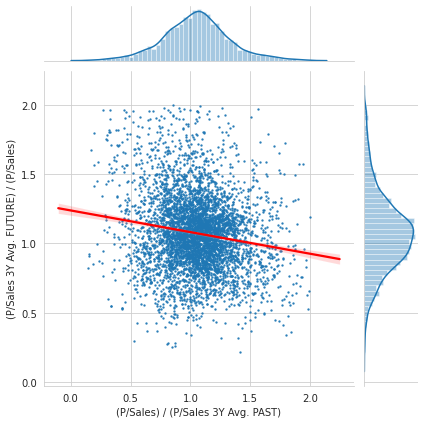

In [28]:
# Remove some of the data-points by setting them to NaN,
# because clipped/limited values can distort this plot.
df_psales3 = sf.clip(df=df_psales, lower=lower, upper=upper,
                     clip=False)

plot_scatter_fit(x=PSALES_REL_PAST, y=PSALES_REL_FUTURE,
                 df=df_psales3);

Let us instead try and make the same scatter-plot but for individual stocks. The following plot shows it for ticker AAPL, which clearly shows strong tendecies for mean reversion, because a recent drop in the P/Sales ratio compared to its PAST 3-year average, is followed by a rise in P/Sales ratio for the FUTURE 3-years.

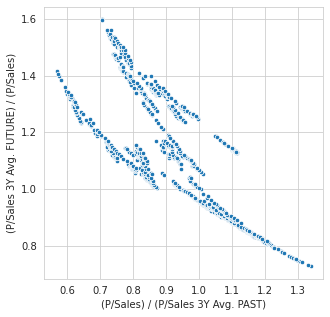

In [29]:
plot_scatter(x=PSALES_REL_PAST, y=PSALES_REL_FUTURE,
             df=df_psales.loc['AAPL']);

The following plot shows it for ticker WMT, which has similar downwards-sloping curves, albeit more spread out.

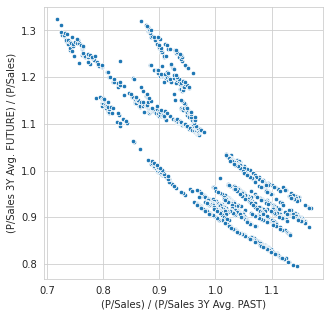

In [30]:
plot_scatter(x=PSALES_REL_PAST, y=PSALES_REL_FUTURE,
             df=df_psales.loc['WMT']);

The following plot shows it for ticker MSFT, which also has downwards-sloping curves, but even more spread out.

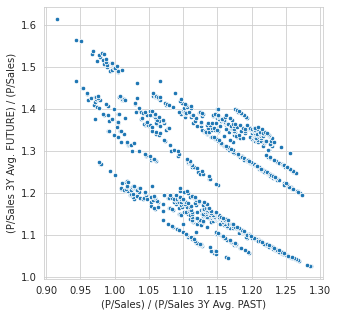

In [31]:
plot_scatter(x=PSALES_REL_PAST, y=PSALES_REL_FUTURE,
             df=df_psales.loc['MSFT']);

We can also make a simple plot of the P/Sales for each stock where the mean is shown as a red line. The following plot is for ticker AAPL which seems to have a tendency for mean-reversion. The P/Sales in the beginning of year 2020 was historically high, so we might "forecast" that it will revert to its historical mean over the next year or so, which would cause the P/Sales ratio to drop maybe 40%, and unless this can be offset by a similar Sales Growth, we might expect AAPL stock to drop significantly over the coming year or so - unless the stock-market has "decided" that it wants to continue paying a historically high P/Sales ratio for AAPL stock.

NOTE: This text was originally written before the March 2020 stock-market crash due to the Corona virus.

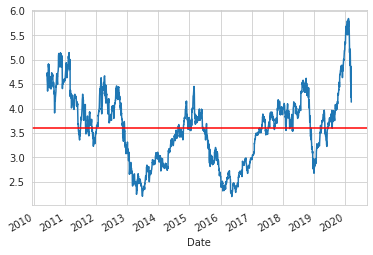

In [32]:
plot_with_mean(df=df_psales.loc['AAPL', PSALES]);

Similarly, we can plot the P/Sales ratio for ticker WMT, which also shows a high P/Sales ratio about 25% above its historical mean in early 2020, so we can draw a similar conclusion, that it might experience a significantly drop over the coming year or two, unless the company either experiences a similar Sales Growth, or the stock-market has "decided" that it wants to permanently value WMT at a higher P/Sales ratio than its historical average.

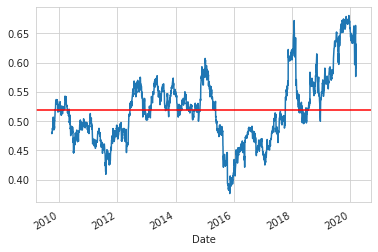

In [33]:
plot_with_mean(df=df_psales.loc['WMT', PSALES]);

The following plot shows the P/Sales ratio for ticker MSFT, which has nearly tripled over the last 10 years, in a nearly continuous increase, without any indication of mean-reversion.

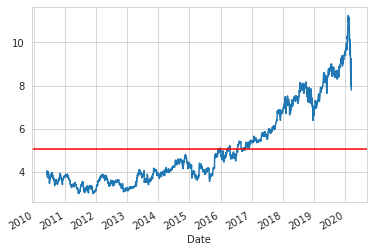

In [34]:
plot_with_mean(df=df_psales.loc['MSFT', PSALES]);

Here is an example of a stock that dropped dramatically in March 2020 due to the Corono-virus panic. This is ticker CCL for the Carnival Corporation which is one of the world's largest cruise-ship operators, which had one of the early virus-incidents on one of their ships. At the time of this writing it is trading at a P/Sales ratio around 0.5. If it is to revert to its mean around 2.1 from the last 10 years, then it would give roughly a 400% return. The question is whether the company will go bankrupt or have to issue more shares at low valuation ratios, in order to survive the Corona-panic. Time will tell if this is a fantastic or terrible investment at these low prices.

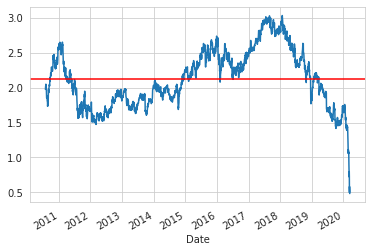

In [35]:
plot_with_mean(df=df_psales.loc['CCL', PSALES]);

Finally, let us try and fit a Multiple Linear Regression model to use the various P/Sales signals to predict the FUTURE 3-year average P/Sales ratio. This has $R^2 = 0.86$ which is only marginally better than if we only used either the current P/Sales ratio, or the PAST 3-year average P/Sales ratio. So there is little or no real advantage to combining these signals when predicting the FUTURE 3-year average P/Sales.

Also note that because the data gets standardized to have 0 mean and 1 standard deviation before fitting the regression model, the fitted coefficients show the relative importance of the predictor signals. Clearly the most important predictive signal is the current P/Sales ratio. The second-most important signal is the PAST 3-year average P/Sales ratio. And of no real importance is the current P/Sales ratio divided by its PAST 3-year average.

In [36]:
# Fit a multiple linear regression model and show the result.
df = df_psales[[PSALES, PSALES_3Y_PAST, PSALES_3Y_FUTURE,
                PSALES_REL_PAST]]
model = regression(df=df, y=PSALES_3Y_FUTURE, standardize=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     P/Sales 3Y Avg. FUTURE   R-squared:                       0.859
Model:                                OLS   Adj. R-squared:                  0.859
Method:                     Least Squares   F-statistic:                 1.214e+06
Date:                    Wed, 18 Mar 2020   Prob (F-statistic):               0.00
Time:                            11:14:13   Log-Likelihood:            -8.1478e+05
No. Observations:                  595743   AIC:                         1.630e+06
Df Residuals:                      595739   BIC:                         1.630e+06
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
P/Sales                                1.9175      0.005    381.173      0.000       1.908       1.927
P/Sales 3Y Avg. PAST                   0.4614      0.005     93.334      0.000       0.452       0.471
(P/Sales) / (P/Sales 3Y Avg. PAST)    -0.0127      0.002     -6.668      0.000      -0.016      -0.009
Constant                               2.8828      0.001   2342.083      0.000       2.880       2.885
==============================================================================
Omnibus:                   143750.752   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3687217.475
Skew:                           0.581   Prob(JB):                         0.00
Kurtosis:                      15.132   Cond. No.                         8.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## P/Sales vs. Other Signals

Let us now investigate if any of the other signals can be used to predict the FUTURE 3-year average P/Sales ratio. First we calculate the linear correlations.

In [37]:
%%time
df_corr = df_signals.corr()
df_corr_3y = df_signals_3y.corr()

CPU times: user 18.2 s, sys: 743 ms, total: 18.9 s
Wall time: 18.4 s


In [38]:
# New column names.
SIGNALS_NORMAL = 'Normal Signals'
SIGNALS_3Y = '3-Year Avg. Signals'

# Create a new DataFrame with the correlations.
data = \
{
    SIGNALS_NORMAL: df_corr[PSALES_3Y_FUTURE],
    SIGNALS_3Y: df_corr_3y[PSALES_3Y_FUTURE]
}
df = pd.DataFrame(data=data)

The table below shows the absolute correlations between the FUTURE 3-year average P/Sales ratio and the various signals. A value of 1 means perfect correlation, while a value of 0 means there is no linear relation between the variables. Here we are only interested in comparing the correlation strength and not the direction, that is why we consider the absolute correlation.

The first column shows the correlations for the normal signals which are calculated with the TTM financial data. The second column shows the correlations for the signals calculated with 3-year PAST averages for the financial data. The only real difference between these two columns seems to be for the P/E and Net Profit Margin, where the correlation is stronger when using the PAST 3-year averages.

What we generally see is that the current P/Sales ratio has the strongest correlation with the FUTURE 3-year average P/Sales ratio. The next strongest correlation is for the PAST 3-year average P/Sales ratio. Then the Gross Profit Margin and Asset Turnover. The P/Book and P/E are also valuation ratios, so we will ignore those.

In [39]:
df.abs().sort_values(by=SIGNALS_NORMAL, ascending=False)

,Normal Signals,3-Year Avg. Signals
P/Sales 3Y Avg. FUTURE,1.000000,1.000000
P/Sales,0.903879,0.895450
P/Sales 3Y Avg. PAST,0.882970,0.882970
Gross Profit Margin,0.547388,0.550507
Asset Turnover,0.437774,0.437289
P/Book,0.299908,0.313731
Sales Growth,0.217111,0.230814
Sales Growth YOY,0.196713,0.214804
P/E,0.195813,0.271600
Current Ratio,0.157852,0.169831


Let us try and fit a Linear Regression Model to some of the signals with highest correlation. The reason we don't fit the regression model to all the signals, is that alot of them contain NaN (Not-a-Number), which results in the entire rows with NaN being removed, so the dataset becomes much smaller, and the correlation numbers already shows that many of the signals are not linearly related to the FUTURE 3-year average P/Sales anyway.

The regression model has $R^2 = 0.86$ which is only marginally better than using only one signal, either the current P/Sales ratio or the PAST 3-year average P/Sales.

Because the data is standardized (to having zero mean and one standard deviation) before the regression model is fitted, the coefficients show us which signals are most important in predicting the FUTURE 3-year average P/Sales ratio, and that is by far the current P/Sales ratio, followed by the PAST 3-year average P/Sales ratio. The Gross Profit Margin, Net Profit Margin, Asset Turnover, and Sales Growth only have a relatively minor effect on the linear regression model.

In [40]:
# Select signals with highest correlation.
df = df_signals[[PSALES_3Y_FUTURE, PSALES, PSALES_3Y_PAST,
                 GROSS_PROFIT_MARGIN, NET_PROFIT_MARGIN,
                 ASSET_TURNOVER, SALES_GROWTH]]

# Fit a multiple linear regression model and show the result.
model = regression(df=df, y=PSALES_3Y_FUTURE, standardize=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     P/Sales 3Y Avg. FUTURE   R-squared:                       0.855
Model:                                OLS   Adj. R-squared:                  0.855
Method:                     Least Squares   F-statistic:                 5.318e+05
Date:                    Wed, 18 Mar 2020   Prob (F-statistic):               0.00
Time:                            11:14:32   Log-Likelihood:            -7.1183e+05
No. Observations:                  541733   AIC:                         1.424e+06
Df Residuals:                      541726   BIC:                         1.424e+06
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
P/Sales                  1.7282      0.003    527.654      0.000       1.722       1.735
P/Sales 3Y Avg. PAST     0.4053      0.003    120.979      0.000       0.399       0.412
Gross Profit Margin      0.0750      0.002     48.056      0.000       0.072       0.078
Net Profit Margin        0.0489      0.001     37.744      0.000       0.046       0.051
Asset Turnover          -0.0655      0.001    -45.870      0.000      -0.068      -0.063
Sales Growth            -0.0562      0.001    -43.573      0.000      -0.059      -0.054
Constant                 2.8131      0.001   2299.638      0.000       2.811       2.816
==============================================================================
Omnibus:                   165847.566   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4337850.336
Skew:                           0.903   Prob(JB):                         0.00
Kurtosis:                      16.745   Cond. No.                         6.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can then try and remove the PAST P/Sales signals and redo the regression. Now we get $R^2 = 0.37$ and the coefficients show us that the Gross Profit Margin is by far the most important of these signals in predicting the FUTURE 3-year average P/Sales ratio.

In [41]:
# Select signals with highest correlation except PAST P/Sales.
df = df_signals[[PSALES_3Y_FUTURE,
                 GROSS_PROFIT_MARGIN, NET_PROFIT_MARGIN,
                 ASSET_TURNOVER, SALES_GROWTH]]

# Fit a multiple linear regression model and show the result.
model = regression(df=df, y=PSALES_3Y_FUTURE, standardize=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     P/Sales 3Y Avg. FUTURE   R-squared:                       0.373
Model:                                OLS   Adj. R-squared:                  0.373
Method:                     Least Squares   F-statistic:                 1.568e+05
Date:                    Wed, 18 Mar 2020   Prob (F-statistic):               0.00
Time:                            11:14:32   Log-Likelihood:            -2.1562e+06
No. Observations:                 1054165   AIC:                         4.312e+06
Df Residuals:                     1054160   BIC:                         4.312e+06
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Gross Profit Margin     0.9288      0.002    444.548      0.000       0.925       0.933
Net Profit Margin       0.2327      0.002    125.331      0.000       0.229       0.236
Asset Turnover         -0.5591      0.002   -272.688      0.000      -0.563      -0.555
Sales Growth            0.3838      0.002    208.051      0.000       0.380       0.387
Constant                2.7000      0.002   1481.614      0.000       2.696       2.704
==============================================================================
Omnibus:                   296969.460   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1094935.742
Skew:                           1.385   Prob(JB):                         0.00
Kurtosis:                       7.154   Cond. No.                         1.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we use the signals calculated from 3-year averages of the financial data, then we get a slightly higher $R^2 = 0.39$, probably because the 3-year average Net Profit Margin is a stronger predictor for FUTURE P/Sales ratios than the TTM Net Profit Margin:

In [42]:
# Select signals with highest correlation except PAST P/Sales.
df = df_signals_3y[[PSALES_3Y_FUTURE,
                    GROSS_PROFIT_MARGIN, NET_PROFIT_MARGIN,
                    ASSET_TURNOVER, SALES_GROWTH]]

# Fit a multiple linear regression model and show the result.
model = regression(df=df, y=PSALES_3Y_FUTURE, standardize=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     P/Sales 3Y Avg. FUTURE   R-squared:                       0.394
Model:                                OLS   Adj. R-squared:                  0.394
Method:                     Least Squares   F-statistic:                 8.840e+04
Date:                    Wed, 18 Mar 2020   Prob (F-statistic):               0.00
Time:                            11:14:33   Log-Likelihood:            -1.0928e+06
No. Observations:                  544405   AIC:                         2.186e+06
Df Residuals:                      544400   BIC:                         2.186e+06
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Gross Profit Margin     0.8332      0.003    294.783      0.000       0.828       0.839
Net Profit Margin       0.4459      0.003    174.401      0.000       0.441       0.451
Asset Turnover         -0.5134      0.003   -186.497      0.000      -0.519      -0.508
Sales Growth            0.3496      0.002    141.262      0.000       0.345       0.354
Constant                2.7693      0.002   1134.388      0.000       2.765       2.774
==============================================================================
Omnibus:                   153378.875   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           574252.393
Skew:                           1.379   Prob(JB):                         0.00
Kurtosis:                       7.208   Cond. No.                         1.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## P/Sales vs. Asset Turnover & Sales Growth

We will now study how some of the individual signals might be used to predict the FUTURE 3-year average P/Sales ratio. First we make a scatter-plot of the Asset Turnover on the x-axis and the FUTURE 3-year average P/Sales on the y-axis. The hue is the PAST 3-year average P/Sales ratio.

The scatter-plot is not completely random. There does seem to be a tendency for the FUTURE 3-year average P/Sales ratio to have an almost reciprocal relation with the Asset Turnover, but there is a very large spread of the data-points.

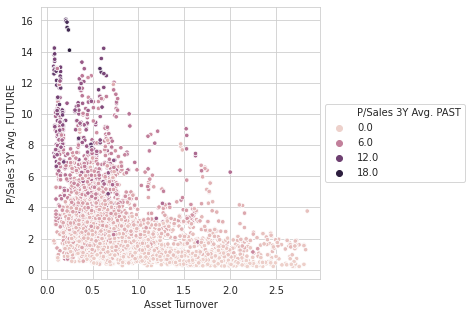

In [43]:
plot_scatter(df=df_signals, x=ASSET_TURNOVER, y=PSALES_3Y_FUTURE,
             hue=PSALES_3Y_PAST);

Let us try and "zoom in" on the points whose PAST 3-year average P/Sales ratio is below 4. This is shown in following scatter-plot, where we can see that there does seem to be a relation between the Asset Turnover, the PAST 3-year average P/Sales ratio, and the FUTURE 3-year average P/Sales.

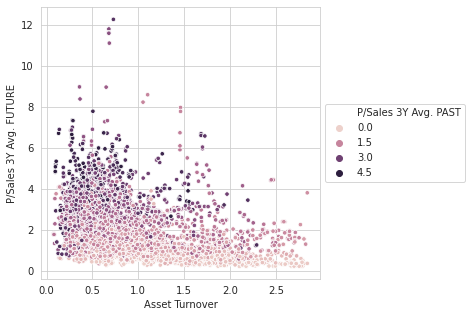

In [44]:
# Select and plot only some of the signals.
mask = (df_signals[PSALES_3Y_PAST] < 4)
df = df_signals.loc[mask]
plot_scatter(df=df, x=ASSET_TURNOVER, y=PSALES_3Y_FUTURE,
             hue=PSALES_3Y_PAST);

Now let us try and make a scatter-plot of the PAST TTM Sales Growth on the x-axis, the FUTURE 3-year average P/Sales ratio on the y-axis, and the hue is the PAST 3-year average P/Sales.

The scatter-plot looks like a large blob of random points. There does not seem to be any simple and clear relation between TTM Sales Growth and FUTURE 3-year average P/Sales ratio.

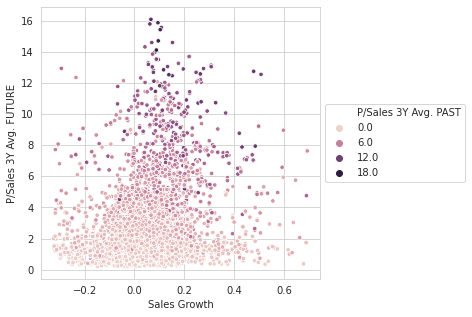

In [45]:
plot_scatter(df=df_signals, x=SALES_GROWTH, y=PSALES_3Y_FUTURE,
             hue=PSALES_3Y_PAST);

We can again try and "zoom in" on the scatter-plot and only show the points whose PAST 3-year average P/Sales ratio is less than 4. But once again the scatter-plot does not seem to show a clear relation between the TTM Sales Growth and FUTURE 3-year average P/Sales ratio.

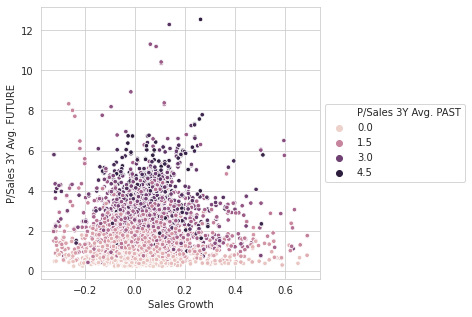

In [46]:
# Select and plot only some of the signals.
mask = (df_signals[PSALES_3Y_PAST] < 4)
df = df_signals.loc[mask]
plot_scatter(df=df, x=SALES_GROWTH, y=PSALES_3Y_FUTURE,
             hue=PSALES_3Y_PAST);

## P/Sales vs. Gross Profit Margin

Let us now study whether the Gross Profit Margin can be used to predict the FUTURE 3-year average P/Sales ratio, so we make a scatter-plot with these data-points on the x- and y-axis. The plot shows there is a clear correlation, although the data-points are quite dispersed and we only get $R^2 = 0.34$.

y = 6.84 * x + -0.37 (R^2=0.34, p=0e+00)


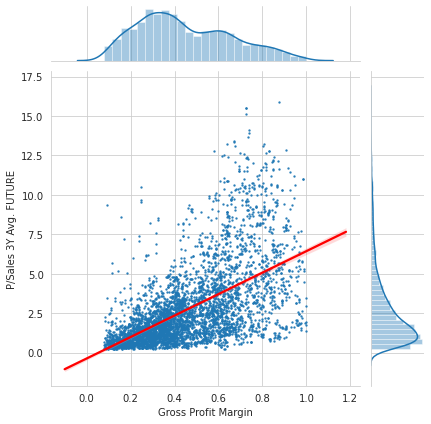

In [47]:
# Only use data-rows where Gross Profit Margin < 1.0
# because it may distort the line-fitting.
mask = (df_signals[GROSS_PROFIT_MARGIN] < 1.0)
df = df_signals.loc[mask]

# Create the scatter-plot.
plot_scatter_fit(df=df, x=GROSS_PROFIT_MARGIN, y=PSALES_3Y_FUTURE);

Let us now make another scatter-plot using the PAST 3-year average Gross Profit Margin on the x-axis, and the FUTURE 3-year average P/Sales ratio on the y-axis. This shows the same kind of correlation and the $R^2$ is nearly the same as in the plot above where we used the TTM Gross Profit Margin on the x-axis.

y = 6.96 * x + -0.35 (R^2=0.35, p=0e+00)


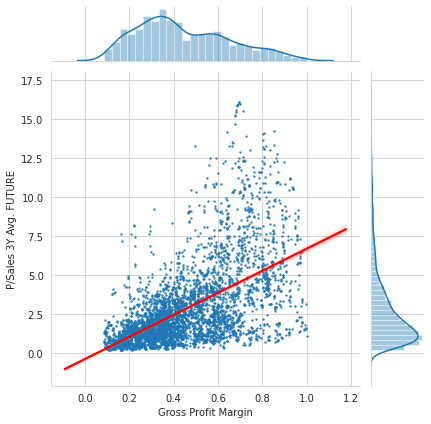

In [48]:
# Only use data-rows where Gross Profit Margin < 1.0
# because it may distort the line-fitting otherwise.
mask = (df_signals_3y[GROSS_PROFIT_MARGIN] < 1.0)
df_3y = df_signals_3y.loc[mask]

# Create the scatter-plot.
plot_scatter_fit(df=df_3y, x=GROSS_PROFIT_MARGIN, y=PSALES_3Y_FUTURE);

We can also combine some of the plots above, by making a scatter-plot of the PAST 3-year average P/Sales ratio on the x-axis, and the FUTURE 3-year average P/Sales ratio on the y-axis, and the hue is the TTM Gross Profit Margin.

This shows that the FUTURE 3-year average P/Sales ratio is strongly correlated with the PAST 3-year average P/Sales ratio, and there is also a correlation between the Gross Profit Margin and P/Sales ratio, so higher Gross Profit Margins tend to have higher P/Sales ratios.

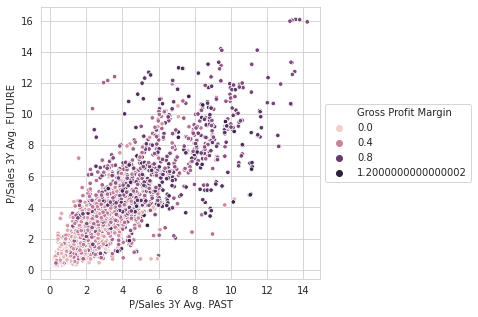

In [49]:
plot_scatter(x=PSALES_3Y_PAST, y=PSALES_3Y_FUTURE,
             hue=GROSS_PROFIT_MARGIN, df=df);

## P/Sales vs. Net Profit Margin

Let us now study whether the Net Profit Margin can be used to predict the FUTURE 3-year average P/Sales ratio, so we make a scatter-plot with these data-points on the x- and y-axis. There seems to be a correlation in the plot, but due to the many outliers, the linear regression has a very poor fit with nearly zero $R^2$.

y = 1.50 * x + 2.55 (R^2=0.01, p=0e+00)


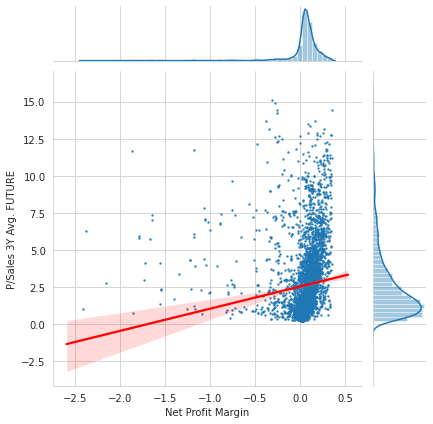

In [50]:
plot_scatter_fit(df=df_signals,
                 x=NET_PROFIT_MARGIN, y=PSALES_3Y_FUTURE);

Let us try and use the PAST 3-year average Net Profit Margin on the x-axis instead. This has only had a minor effect on the outliers, so the line still has a very poor fit.

y = 4.47 * x + 2.35 (R^2=0.07, p=0e+00)


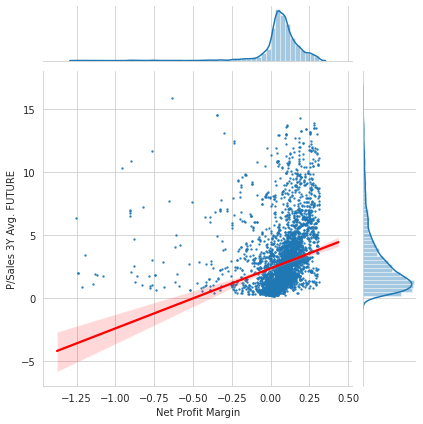

In [51]:
plot_scatter_fit(df=df_signals_3y,
                 x=NET_PROFIT_MARGIN, y=PSALES_3Y_FUTURE);

So let us try and only use the data-points with positive Net Profit Margin. Now the correlation with the FUTURE 3-year average P/Sales ratio is much clearer and we get a linear fit with $R^2 = 0.4$.

y = 21.13 * x + 0.59 (R^2=0.40, p=0e+00)


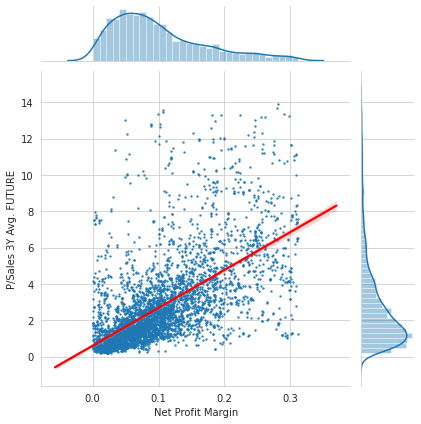

In [52]:
# Only use the rows with positive Net Profit Margin.
mask = (df_signals_3y[NET_PROFIT_MARGIN] > 0.0)
df = df_signals_3y.loc[mask]

# Make the scatter-plot.
plot_scatter_fit(df=df, x=NET_PROFIT_MARGIN, y=PSALES_3Y_FUTURE);

## Net vs. Gross Profit Margin

In the sections above, we found correlations with similar $R^2$ values for both Net and Gross Profit Margin versus the FUTURE 3-year average P/Sales ratio. Let us now compare the Net and Gross Profit Margins to see if they are strongly correlated with each other. We do this by calculating the ratio between them and showing various statistics and plots.

In [53]:
# Calculate ratio between Net and Gross Profit Margin.
df = df_signals_3y[NET_PROFIT_MARGIN] / df_signals_3y[GROSS_PROFIT_MARGIN]

# Show basic statistics.
df.describe()

count    1.905977e+06
mean     8.507507e-02
std      4.430154e-01
min     -1.109272e+01
25%      4.108827e-02
50%      1.624370e-01
75%      2.706583e-01
max      1.859813e+00
dtype: float64

From the statistics table above, we see that the median ratio between Net and Gross Profit Margin is around 0.16. We can also plot a histogram to show the distribution of the ratios between Net and Gross Profit Margin. We clip the ratios between -1 and 1 to remove outliers.

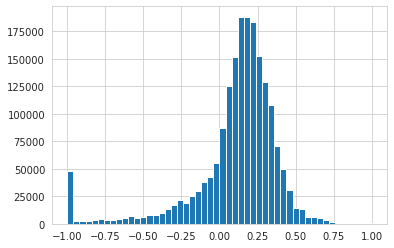

In [54]:
df.clip(lower=-1, upper=1).hist(bins=50);

We can also make a scatter-plot with the Gross Profit Margin on the x-axis and the Net Profit Margin on the y-axis. These are the PAST 3-year average values. The plot clearly shows a correlation, but the linear fit has zero $R^2$ because of outliers.

y = 0.04 * x + 0.02 (R^2=0.00, p=0e+00)


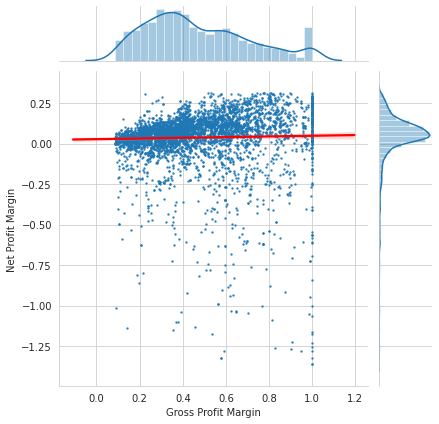

In [55]:
plot_scatter_fit(df=df_signals_3y,
                 x=GROSS_PROFIT_MARGIN, y=NET_PROFIT_MARGIN);

Let us remove the outliers for both the Net and Gross Profit Margins. This gives a linear fit with $R^2 = 0.29$ and formula:

$$
    Net\ Profit\ Margin = 0.18 \cdot Gross\ Profit\ Margin + 0.02
$$

This is nearly the same relation between Net and Gross Profit Margin as the median ratio of 0.16 shown in the statistics table above.

y = 0.18 * x + 0.02 (R^2=0.29, p=0e+00)


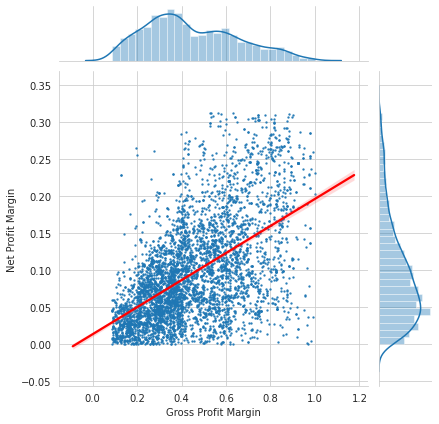

In [56]:
# Only use some of the data-points.
mask = (df_signals_3y[NET_PROFIT_MARGIN] >= 0.0) \
     & (df_signals_3y[GROSS_PROFIT_MARGIN] < 1.0)
df = df_signals_3y.loc[mask]

# Make the scatter-plot.
plot_scatter_fit(df=df, x=GROSS_PROFIT_MARGIN, y=NET_PROFIT_MARGIN);

## Conclusion

Forecasting the change in valuation ratio such as the P/Sales ratio is an essential component of long-term stock forecasting. This was a statistical study of which signals could be used to predict the FUTURE 3-year average P/Sales ratio. These are the results:

- The strongest predictor for the FUTURE 3-year average P/Sales ratio is the CURRENT P/Sales ratio and the PAST 3-year average P/Sales ratio, with the CURRENT P/Sales ratio having slightly stronger correlation with the FUTURE P/Sales ratios.

- The P/Sales ratio does not exhibit mean-reversion in the traditional sense. It seems that **in aggregate**, the stocks tend to have the same average P/Sales ratios in the FUTURE 3-years as they did in the PAST 3-years. But the **individual** stocks can experience significant changes in their P/Sales ratios.

- Some individual stocks such as AAPL and WMT seem to have had mean-reverting P/Sales ratios in the past 10 years, while other stocks such as MSFT have had continually increasing P/Sales ratios in the past 10 years. We cannot tell from this study alone whether that will continue in the future.

- The Gross Profit Margin predicted the FUTURE 3-year average P/Sales ratio with $R^2 \simeq 0.35$.

- The PAST 3-year average Net Profit Margin predicted the FUTURE 3-year average P/Sales ratio with $R^2 \simeq 0.4$ - provided we only use the positive Net Profit Margin, otherwise the $R^2$ was zero due to outliers.

- The Gross Profit Margin and *positive* Net Profit Margin were correlated with $R^2 \simeq 0.3$.

CAVEAT: We used data for a fairly short period of time, which ended in March 2020 and only went back about 6-7 years on average for the individual stocks, with the max period being 11 years for one stock. Ideally this kind of study would be done with 20-30 years of data, in which case there might be stronger signs of mean-reversion for the P/Sales ratio over 5-10 year periods.

## License (MIT)

Copyright (c) 2020 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.